## CSI feedback comments NLP - Sentiment analysis

## I: setup, preparing and cleaning data

In [1]:
## - libraries, modules and frameworks:
import pandas as pd, numpy as np, re, nltk, matplotlib.pyplot as plt, seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import dask.dataframe as dd
from tqdm import tqdm

## - visualisation setup:
plt.style.use("ggplot")
%matplotlib inline

In [2]:
def sql_conn(db):
    """
    1. Description: function to initiate a mssql database connection
    3. Parameters:
        :param 1 db => mssql database name
    3. Returns: mssql connection engine
    """
    
    main = ["xxx"]
    
    sql_driver = (main[0].replace("{", "")
                 .replace("}", ""))
    
    sql_path = f"mssql://@{main[1]}/{db}?driver={sql_driver}"
    engine = (
        create_engine(
            sql_path)
    )
    return engine


In [3]:
def get_data(col1,
             col2,
             tbl):
    """
    1. Description: function to query and to fetch necessary data/columns from a sql table
    2. Parameters: col1, col2 and tbl
        :param 1 col1 => column one or submissiond_id column
        :param 1 col2 => column two or feedback_comments/feedback/comments
        :param 1 tbl => mssql table name
    3. Returns: df/dataframe
    """
    
    # ***********************************************************
    # specify database name for a previous function sql_conn(db):
    db = "xxx"
    
    Session = (
        sessionmaker(
            bind = sql_conn(db)))
    
    with Session() as session:
        # ****************************************
        # specify column1, column2 and table name:
        query = f"select {col1}, {col2} from {tbl}"
        df = (pd.read_sql(query,
                         con = sql_conn(db)))
    return df

In [4]:
# setup a dataframe:
pd.set_option("display.max_colwidth",
              None)

pd.set_option("display.max_rows",
              None)

# call the function get_data(col1, col2, tbl)
# specify: col1, col2 and table name:
df = get_data("submission_id",
              "feedback_comment",
              "csi")

In [5]:
# replace None, NULL and nan values with 'no comment':
df.iloc[:, 1] = (df.iloc[:, 1].
                 replace(np.nan,
                         "no comment"))

In [6]:
def remove_symbols(txt):
    """
    1. Description: function to remove symbols and numerical values
    3. Parameters:
        :param 1 txt => df/dataframe column
    3. Returns: regex pattern
    """
    
    pattern = r'[^a-zA-Z.,!?\'"]+'
    return re.sub(pattern, " ", txt)

# replace "+" with ""
df.iloc[:, 1] = (df.iloc[:, 1].
                 str.replace(r"\+", "and",
                             regex=True))

# apply the function remove_symbols(txt):
df.iloc[:, 1] = df.iloc[:, 1].apply(remove_symbols)

# stripg values from both sides:
df.iloc[:, 1] = df.iloc[:, 1].apply(lambda x: x.strip())

## II: Deep translator model for translation:

In [7]:
def translate_text(txt):
    """
    1. Description: function to translate text to english
    3. Parameters:
        :param 1 txt => df/dataframe column
    3. Returns: translated function
    """
    
    # *****************
    # specify source language:
    return GoogleTranslator(source = "fr", target = "en").translate(txt)

In [8]:
def multiprocess_translation(np, col):
    """
    1. Description: function to initiate multiprocessing translation procedure with dask
    3. Parameters:
        :param 1 np => number of partitions regarding a cpu
        :param 2 col => df/dataframe column
    3. Returns: df/dataframe
    """
    
    ddata = dd.from_pandas(df, npartitions=np)
    
    with ProgressBar():
        dff = (ddata.map_partitions(lambda df:
                                    df.apply((lambda row: translate_text(row[col])), 
                                             axis=1)).compute(scheduler = "processes"))
    df["translated_column"] = dff
    return df

# *****************************************************
# apply the function multiprocess_translation(np, col):
# specify number of partitions and column name:
df = multiprocess_translation(36, "feedback_comment")

# check:
df.tail(10)

[########################################] | 100% Completed | 18.2s


,submission_id,feedback_comment,translated_column
351,6127338,besoin d'ambulance,need ambulance
352,6127344,besoin d'ambulance,need ambulance
353,6127348,"besoin de la disponibilit des services tout moment, ambulance","need the availability of services at all times, ambulance"
354,6127366,ambulance,ambulance
355,6127374,besoin d'ambulance,need ambulance
356,6127351,Besoin de salle d'observation,Need observation room
357,6127354,Augment les m dicaments,increase drugs
358,6127376,Besoin d'ambulance,Ambulance needed
359,6127379,Besoin de salle d'observation,Need observation room
360,6127381,Azgemnter les m dicaments,Azgemnter drugs


## III: Additional setup and EDA:

In [9]:
# additional modifications:
df["translated_column"] = df["translated_column"].apply(lambda x: x.lower())
df["translated_column"] = df["translated_column"].replace("", "no comment")
df["translated_column"] = df["translated_column"].replace("yes", "no comment")
df["translated_column"] = df["translated_column"].replace("no", "no comment")

<AxesSubplot: title={'center': 'Top 10 comments'}, xlabel='Comments', ylabel='Count of comments'>

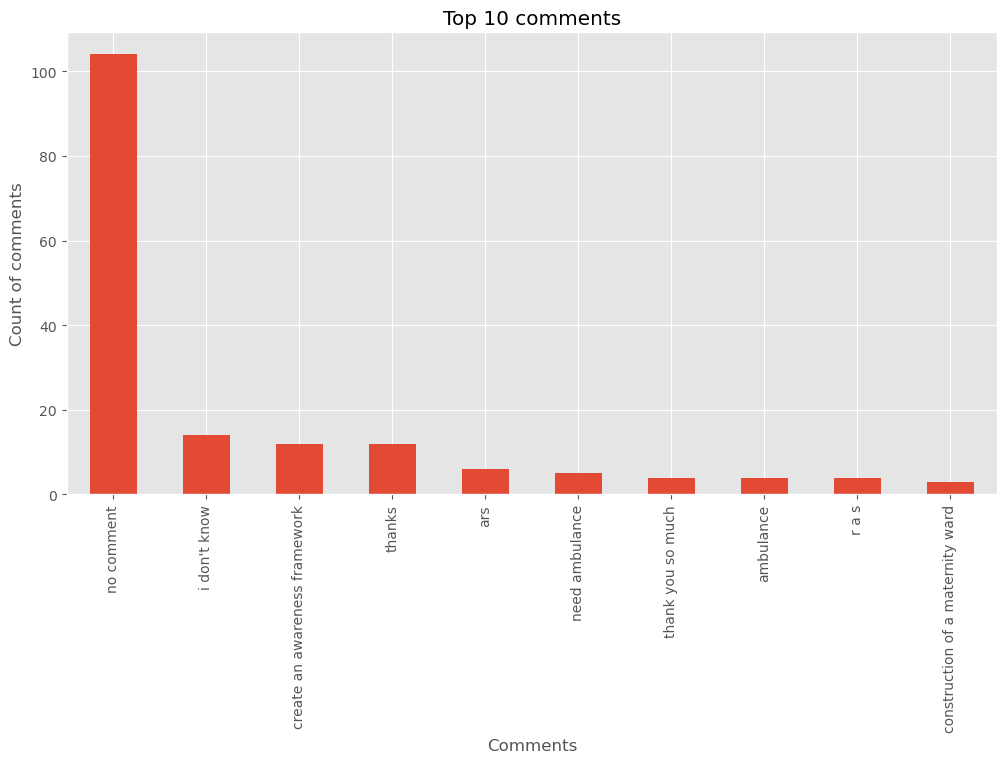

In [10]:
def eda():
    """
    1. Description: function for exploratory data analysis
    3. Parameters: None
    3. Returns: bar chart
    """
    
    data = (df.iloc[:, 2].
            value_counts().sort_values(ascending = False)[:10].
            plot(kind = "bar", figsize = (12, 6)))
    plt.title("Top 10 comments")
    plt.xlabel("Comments")
    plt.ylabel("Count of comments")
    return data

# call the function eda():
eda()

In [11]:
# ratio (%) between "no comment" and the rest of df:
print("Percentage of 'no comments': " + str(round(((df[df["translated_column"] == "no comment"]
                  .count()[0]) / (len(df)) * 100), 1)) + "%")

Percentage of 'no comments': 28.8%


In [12]:
# extract everything except "no comment" values:
df = df.query("translated_column != 'no comment'")

## IV: Vader model for sentiment analysis:

In [13]:
def polarisation(idx):
    """
    1. Description: function for polarisation
    3. Parameters:
        :param 1 idx => submission_id or id column with unique values
    3. Returns: a dictionary of polarity scores from -1 to 1
    """
    sia = SentimentIntensityAnalyzer()
    
    res = {}
    tqdm.pandas(desc = "Applying machine learning model...")
    for i, row in tqdm(df.iterrows(), total = len(df)):
        text = row["translated_column"]
        myid = row[idx]
        res[myid] = sia.polarity_scores(text)
    return res

In [14]:
def df_final():
    """
    1. Description: function for adding polarity scores within a df
    3. Parameters: None
    3. Returns: df/dataframe
    """
    
    # *********************************************************
    # specify for polarisation function a column name:
    vader_model = pd.DataFrame(polarisation("submission_id")).T
    
    vader_model = (vader_model
                   .reset_index()
                   .rename(columns = {"index":"submission_id"}))
    
    vader_model = (vader_model
                   .merge(right = df,
                          how = "left",
                          on = "submission_id"))
    return vader_model

In [15]:
# call the main polarisation function:
vaders = df_final()

# check:
vaders.tail(10)

100%|██████████████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 4955.23it/s]


,submission_id,neg,neu,pos,compound,feedback_comment,translated_column
247,6127338,0.0,1.000,0.000,0.0000,besoin d'ambulance,need ambulance
248,6127344,0.0,1.000,0.000,0.0000,besoin d'ambulance,need ambulance
249,6127348,0.0,1.000,0.000,0.0000,"besoin de la disponibilit des services tout moment, ambulance","need the availability of services at all times, ambulance"
250,6127366,0.0,1.000,0.000,0.0000,ambulance,ambulance
251,6127374,0.0,1.000,0.000,0.0000,besoin d'ambulance,need ambulance
252,6127351,0.0,1.000,0.000,0.0000,Besoin de salle d'observation,need observation room
253,6127354,0.0,0.303,0.697,0.3182,Augment les m dicaments,increase drugs
254,6127376,0.0,1.000,0.000,0.0000,Besoin d'ambulance,ambulance needed
255,6127379,0.0,1.000,0.000,0.0000,Besoin de salle d'observation,need observation room
256,6127381,0.0,1.000,0.000,0.0000,Azgemnter les m dicaments,azgemnter drugs


## V: Additional visualisations and seting up polarity scores:

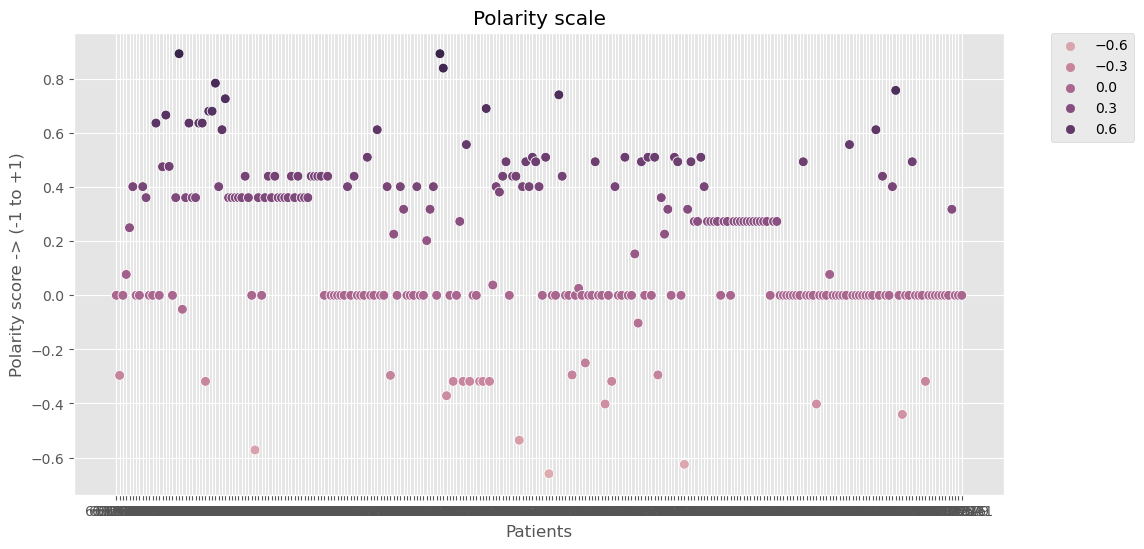

In [16]:
def scatter_plot():
    """
    1. Description: function for creating a scatter plot
    3. Parameters: None
    3. Returns: scatter plot for polarisation rate between -1 and 1
    """
    
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.scatterplot(data = vaders,
                    ax = ax,
                    x = "submission_id",
                    y = "compound",
                    hue = "compound",
                    hue_norm = (-1, +1),
                    s = 50,
                    legend = "brief")
    plt.title("Polarity scale")
    plt.xlabel("Patients")
    plt.ylabel("Polarity score -> (-1 to +1)")
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
    
# calling the function scatter_plot():
scatter_plot()

In [17]:
def preselect_round():
    """
    1. Description: function to round values for compound score
    3. Parameters: None
    3. Returns: rounded values for compound column
    """
    
    vaders["compound"] = vaders["compound"].round(decimals = 1)
    return vaders

In [18]:
def polarity_scores(val):
    """
    1. Description: function for polarity scores from 1 to 5
    3. Parameters:
        :param 1 val => df/dataframe column in this case "compound"
    3. Returns: a df/dataframe
    """
    
    if val >= -1 and val <= -0.6:
        return 1
    elif val > -0.6 and val <= -0.1:
        return 2
    elif val == 0.0:
        return 3
    elif val > 0.0 and val <= 0.5:
        return 4
    elif val > 0.5:
        return 5
    
# apply the function preselect_round():
df = preselect_round()

# apply the function polarity_scores(val):
df["pol_cat_score"] = df["compound"].apply(polarity_scores)

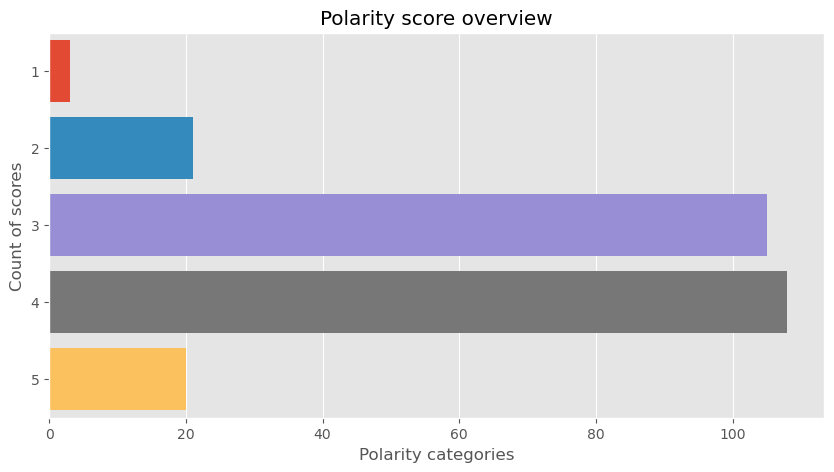

In [19]:
def bar_chart():
    """
    1. Description: function to create a bar chart with categories
    3. Parameters: None
    3. Returns: a barc chart
    """
    
    fig, ax = plt.subplots(figsize = (10, 5))
    sns.countplot(data = df, 
                  y = "pol_cat_score",
                  saturation = 1)
    plt.title("Polarity score overview")
    plt.xlabel("Polarity categories")
    plt.ylabel("Count of scores")
    
# calling the function bar_chart():
bar_chart()

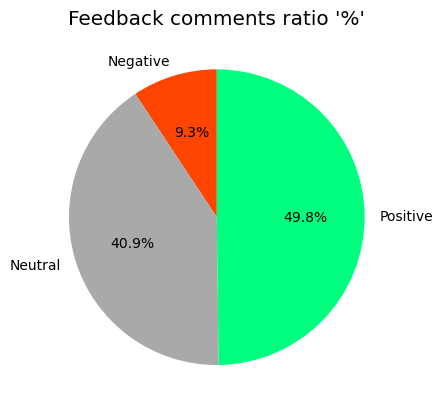

In [20]:
def pie_chart():
    """
    1. Description: function to create a pie chart
    3. Parameters: None
    3. Returns: a pie chart
    """
    
    neg = round(df.query("pol_cat_score == 1 or pol_cat_score == 2")
                .count()[0] / len(df) * 100, 1)
    
    neu = round(df.query("pol_cat_score == 3")
                .count()[0] / len(df) * 100, 1)
    
    pos = round(df.query("pol_cat_score == 4 or pol_cat_score == 5")
                .count()[0] / len(df) * 100, 1)
    
    # data setup:
    sizes = [neg, neu, pos]
    labels = ["Negative", "Neutral", "Positive"]
    colors = ["orangered", "darkgrey", "springgreen"]
    
    # pie chart:
    plt.pie(sizes,
            labels = labels,
            colors = colors,
            autopct = "%1.1f%%",
            startangle = 90)
    plt.title("Feedback comments ratio '%'")
    
# calling the function pie_chart():
pie_chart()

## VI: save the file as a final df/dataframe

In [21]:
def save_df(file_name):
    """
    1. Description: function for saving the .csv flat file
    3. Parameters:
        :param 1 file_name => name of the file
    3. Returns: saved .csv flat file in default folder
    """
    
    new_df = df.iloc[:, [0, 5, 6, 4, 7]]
    new_df.to_csv(file_name + ".csv", index = False)
    
# calling the function save_df(file_name):
save_df("xxx")